In [51]:
import numpy as np
import ot
import ot.plot

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.transform import rotate
from skimage.util import img_as_float, random_noise
from skimage.filters import gaussian

import functions.xor_rxor_with_otp_functions as fn
from proglearn.sims import generate_gaussian_parity
from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

from joblib import Parallel, delayed

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

In [2]:
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
data_x = np.concatenate([X_train, X_test])
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])

In [3]:
idx_1 = np.where(data_y == 0)[0]
idx_2 = np.where(data_y == 1)[0]
idx_3 = np.where(data_y == 2)[0]
idx_4 = np.where(data_y == 3)[0]

In [85]:
task1_x = np.concatenate((data_x[idx_1[0:250]], data_x[idx_2[0:250]]))
task2_x = np.concatenate((data_x[idx_1[250:500]], data_x[idx_2[250:500]]))

task1_y = np.concatenate((data_y[idx_1[0:250]], data_y[idx_2[0:250]])).ravel()
task2_y = np.concatenate((data_y[idx_2[250:500]], data_y[idx_1[250:500]])).ravel()

test_x = np.concatenate((data_x[idx_1[500:600]], data_x[idx_2[500:600]]))
test_y = np.concatenate((data_y[idx_1[500:600]], data_y[idx_2[500:600]])).ravel()

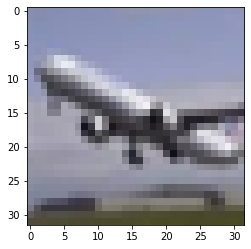

In [5]:
plt.imshow((task2_x[0].reshape(32, 32, 3)))

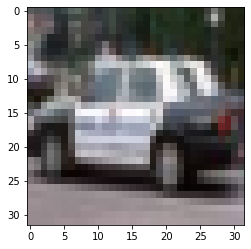

In [7]:
plt.imshow((task1_x[400].reshape(32, 32, 3)))

In [88]:
task1_mean = np.mean(task1_x, axis=0)
task1_std = np.std(task1_x, axis=0)

In [89]:
task1_normalized = (task1_x - task1_mean)/task1_std

In [90]:
from sklearn.utils import shuffle

X, y = shuffle(task1_normalized, task1_y)

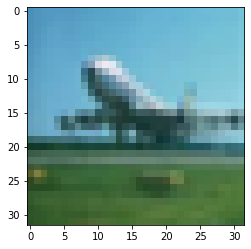

In [41]:
plt.imshow((task1_x[100].reshape(32, 32, 3)))

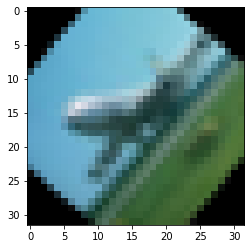

In [53]:
img_rotated = rotate((task1_x[100].reshape(32, 32, 3)), 50)
plt.imshow(img_rotated)

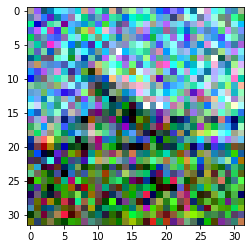

In [52]:
sigma = 0.25
noisy = random_noise((task1_x[100].reshape(32, 32, 3)), var=sigma ** 2)
plt.imshow(noisy)

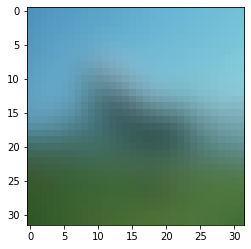

In [58]:
gauss = gaussian((task1_x[100].reshape(32, 32, 3)), sigma=2.5, multichannel=True)
plt.imshow(gauss)

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
task1_decomp = pca.fit(task1_normalized).transform(task1_normalized)

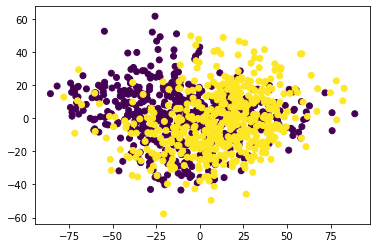

In [26]:
fig = plt.figure()
plt.scatter(task1_decomp[:,0], task1_decomp[:,1], c=task1_y)

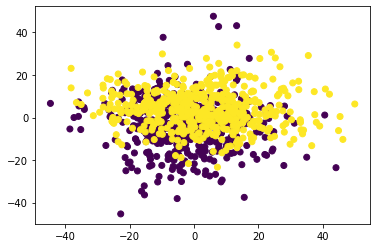

In [27]:
fig = plt.figure()
plt.scatter(task1_decomp[:,2], task1_decomp[:,3], c=task1_y)

In [66]:
def experiment(rotation_angle=None, noise=None, gauss=None):
    n_trees=20
    max_depth=30

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )

    #ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-2)
    #ot_sinkhorn.fit(Xs=X_task2.copy(), Xt=X_task1.copy(), ys=y_task2.copy(), yt=y_task1.copy())
    #transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=X_task2.copy())
    #X_task2 = transp_Xs_sinkhorn
            
    #ot_lasso = ot.da.SinkhornL1l2Transport(reg_e=0.1, max_iter=30)
    #ot_lasso.fit(Xs=X_task2.copy(), Xt=X_task1.copy(), ys=y_task2.copy(), yt=y_task1.copy())
    #transp_Xs_lasso = ot_lasso.transform(Xs=X_task2.copy())
    #X_task2 = transp_Xs_lasso

    progressive_learner.add_task(task1_x, task1_y, num_transformers=n_trees) 
    
    tmp_data = task2_x.copy()
    tmp = np.zeros((32*32*3), dtype=int)
    total_data = tmp_data.shape[0]
    
    if rotation_angle:
        for i in range(total_data):
            tmp = rotate(tmp_data[i].reshape(32, 32, 3), rotation_angle)
            tmp_data[i] = tmp.reshape(32*32*3)
    
    if noise:
        for i in range(total_data):
            tmp = random_noise((tmp_data[i].reshape(32, 32, 3)), var=noise ** 2)
            tmp_data[i] = tmp.reshape(32*32*3)
    
    if gauss:
        for i in range(total_data):
            tmp = gaussian((tmp_data[i].reshape(32, 32, 3)), sigma=gauss, multichannel=True)
            tmp_data[i] = tmp.reshape(32*32*3)
    
    progressive_learner.add_task(tmp_data, task2_y, num_transformers=n_trees)

    uf_task1 = progressive_learner.predict(test_x, transformer_ids=[0], task_id=0)
    l2f_task1=progressive_learner.predict(test_x, task_id=0)

    errors = np.zeros(2, dtype=float)
    acc_uf = (uf_task1 == test_y).sum()/uf_task1.shape[0]
    acc_l2f = (l2f_task1 == test_y).sum()/l2f_task1.shape[0]
    errors[0] = 1 - acc_uf
    errors[1] = 1 - acc_l2f

    return errors

In [9]:
errors = np.array(Parallel(n_jobs=-1, verbose=1)(delayed(experiment)() for _ in range(20)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.8s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


In [10]:
te = (errors[:,0]/errors[:,1]).sum()/errors.shape[0]
print("average TE with no data transformation: " + str(te))

average TE with no data transformation: 0.9887905934243337


In [91]:
errors = np.array(Parallel(n_jobs=-1, verbose=1)(delayed(experiment)() for _ in range(20)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   56.6s finished


In [92]:
te = (errors[:,0]/errors[:,1]).sum()/errors.shape[0]
print("average TE with flipped labels: " + str(te))

average TE with flipped labels: 0.9861697530708204


In [30]:
angle_sweep = np.arange(0, 91, 10)

In [31]:
mean_te1 = np.zeros(len(angle_sweep), dtype=float)
gen_error1 = []

for ii, angle in enumerate(angle_sweep):
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                rotation_angle = angle
            )
            for _ in range(10)
        )
    )
    gen_error1.append(error)
    mean_te1[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   25.7s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   11.3s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [46]:
noise_sweep = np.arange(0, 0.26, 0.05)

In [48]:
mean_te2 = np.zeros(len(noise_sweep), dtype=float)
gen_error2 = []

for ii, sigma in enumerate(noise_sweep):
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                noise = sigma
            )
            for _ in range(20)
        )
    )
    
    gen_error2.append(error)
    mean_te2[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   26.7s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   14.5s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   15.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [64]:
gauss_sweep = np.arange(0, 2.6, 0.5)

In [67]:
mean_te3 = np.zeros(len(gauss_sweep), dtype=float)
gen_error3 = []

for ii, sigma in enumerate(gauss_sweep):
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                gauss = sigma
            )
            for _ in range(20)
        )
    )
    
    gen_error3.append((np.mean(error[:, 0]), np.mean(error[:, 1])))
    mean_te3[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   55.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   28.2s finished


In [69]:
print(gen_error3)

[(0.23874999999999996, 0.23874999999999993), (0.24250000000000002, 0.24475000000000002), (0.242, 0.2435), (0.23975, 0.24375), (0.25025, 0.25175000000000003), (0.23049999999999998, 0.23049999999999998)]


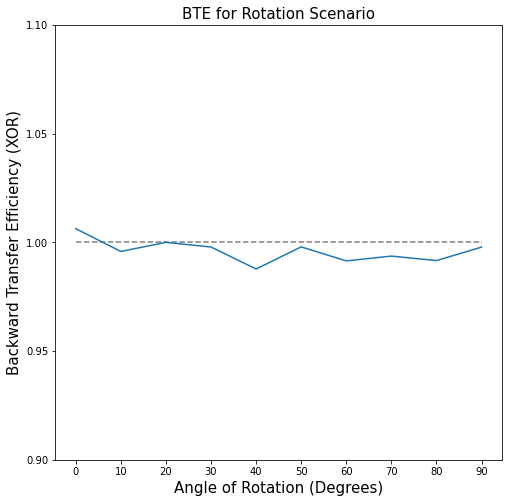

In [99]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(angle_sweep, mean_te)
ax.set_xticks(range(0, 91, 10))
ax.tick_params(labelsize=10)
ax.set_title("BTE for Rotation Scenario", fontsize=15)
ax.set_xlabel("Angle of Rotation (Degrees)", fontsize=15)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=15)
ax.hlines(1, 0, 90, colors="grey", linestyles="dashed", linewidth=1.5)
ax.set_yticks([0.9, 0.95, 1, 1.05, 1.1])

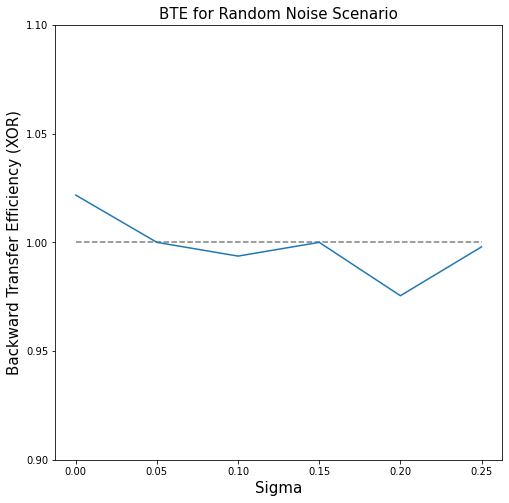

In [97]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(noise_sweep, mean_te2)
ax.tick_params(labelsize=10)
ax.set_title("BTE for Random Noise Scenario", fontsize=15)
ax.set_xlabel("Sigma", fontsize=15)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=15)
ax.hlines(1, 0, 0.25, colors="grey", linestyles="dashed", linewidth=1.5)
ax.set_xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_yticks([0.9, 0.95, 1, 1.05, 1.1])

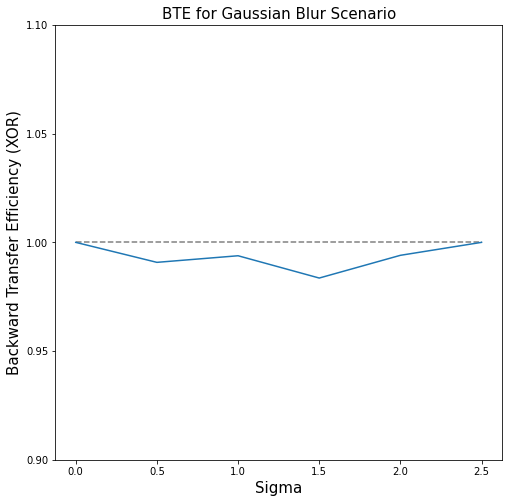

In [100]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
ax.plot(gauss_sweep, mean_te3)
ax.tick_params(labelsize=10)
ax.set_xlabel("Sigma", fontsize=15)
ax.set_title("BTE for Gaussian Blur Scenario", fontsize=15)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=15)
ax.hlines(1, 0, 2.5, colors="grey", linestyles="dashed", linewidth=1.5)
ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5])
ax.set_yticks([0.9, 0.95, 1, 1.05, 1.1])

In [101]:
n_trees=20
max_depth=30
#noise = 0.1
#rotation_angle = 45
gauss = 1

default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}

default_decider_class = SimpleArgmaxAverage
default_decider_kwargs = {"classes": np.arange(2)}
progressive_learner = ProgressiveLearner(
    default_transformer_class=default_transformer_class,
    default_transformer_kwargs=default_transformer_kwargs,
    default_voter_class=default_voter_class,
    default_voter_kwargs=default_voter_kwargs,
    default_decider_class=default_decider_class,
    default_decider_kwargs=default_decider_kwargs,
)

progressive_learner.add_task(task1_x, task1_y, num_transformers=n_trees) 
    
#tmp_data = task2_x.copy()
#tmp = np.zeros((32*32*3), dtype=int)
#total_data = tmp_data.shape[0]
    
#if rotation_angle:
#    for i in range(total_data):
#        tmp = rotate(tmp_data[i].reshape(32, 32, 3), rotation_angle)
#        tmp_data[i] = tmp.reshape(32*32*3)
    
#if noise:
#    for i in range(total_data):
#        tmp = random_noise((tmp_data[i].reshape(32, 32, 3)), var=noise ** 2)
#        tmp_data[i] = tmp.reshape(32*32*3)
    
if gauss:
    for i in range(total_data):
        tmp = gaussian((tmp_data[i].reshape(32, 32, 3)), sigma=gauss, multichannel=True)
        tmp_data[i] = tmp.reshape(32*32*3)
    
progressive_learner.add_task(tmp_data, task2_y, num_transformers=n_trees)

#progressive_learner.add_task(task2_x, task2_y, num_transformers=n_trees)

uf_task1 = progressive_learner.predict(test_x, transformer_ids=[0], task_id=0)
l2f_task1=progressive_learner.predict(test_x, task_id=0)

leaf_nodes_0 = []
leaf_nodes_1 = []
vote_per_transformer_id = []
for transformer_id in progressive_learner.task_id_to_decider[0].transformer_id_to_voters.keys():
    vote_per_bag_id = []
    for bag_id in range(len(progressive_learner.task_id_to_decider[0].transformer_id_to_transformers[transformer_id])):
        transformer = progressive_learner.task_id_to_decider[0].transformer_id_to_transformers[transformer_id][bag_id]
        X_transformed = transformer.transform(test_x)
        if transformer_id == 0:
            leaf_nodes_0.append(X_transformed)
        if transformer_id == 1:
            leaf_nodes_1.append(X_transformed)
        voter = progressive_learner.task_id_to_decider[0].transformer_id_to_voters[transformer_id][bag_id]
        vote = voter.predict_proba(X_transformed)
        vote_per_bag_id.append(vote)
    vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

errors = np.zeros(2, dtype=float)
acc_uf = (uf_task1 == test_y).sum()/uf_task1.shape[0]
acc_l2f = (l2f_task1 == test_y).sum()/l2f_task1.shape[0]
errors[0] = 1 - acc_uf
errors[1] = 1 - acc_l2f


In [102]:
errors

array([0.24, 0.24])

In [103]:
vote_per_transformer_id

[array([[0.90615083, 0.09384917],
        [0.71338987, 0.28661013],
        [0.77619697, 0.22380303],
        [0.33368197, 0.66631803],
        [0.28946991, 0.71053009],
        [0.68162164, 0.31837836],
        [0.63319451, 0.36680549],
        [0.91955233, 0.08044767],
        [0.90142199, 0.09857801],
        [0.16280741, 0.83719259],
        [0.94136972, 0.05863028],
        [0.92795397, 0.07204603],
        [0.37796334, 0.62203666],
        [0.15025175, 0.84974825],
        [0.65014143, 0.34985857],
        [0.22499424, 0.77500576],
        [0.90863599, 0.09136401],
        [0.68798807, 0.31201193],
        [0.79209424, 0.20790576],
        [0.90049671, 0.09950329],
        [0.83614971, 0.16385029],
        [0.89286445, 0.10713555],
        [0.6822032 , 0.3177968 ],
        [0.37295598, 0.62704402],
        [0.78810381, 0.21189619],
        [0.94494115, 0.05505885],
        [0.84026975, 0.15973025],
        [0.70846799, 0.29153201],
        [0.4045347 , 0.5954653 ],
        [0.906

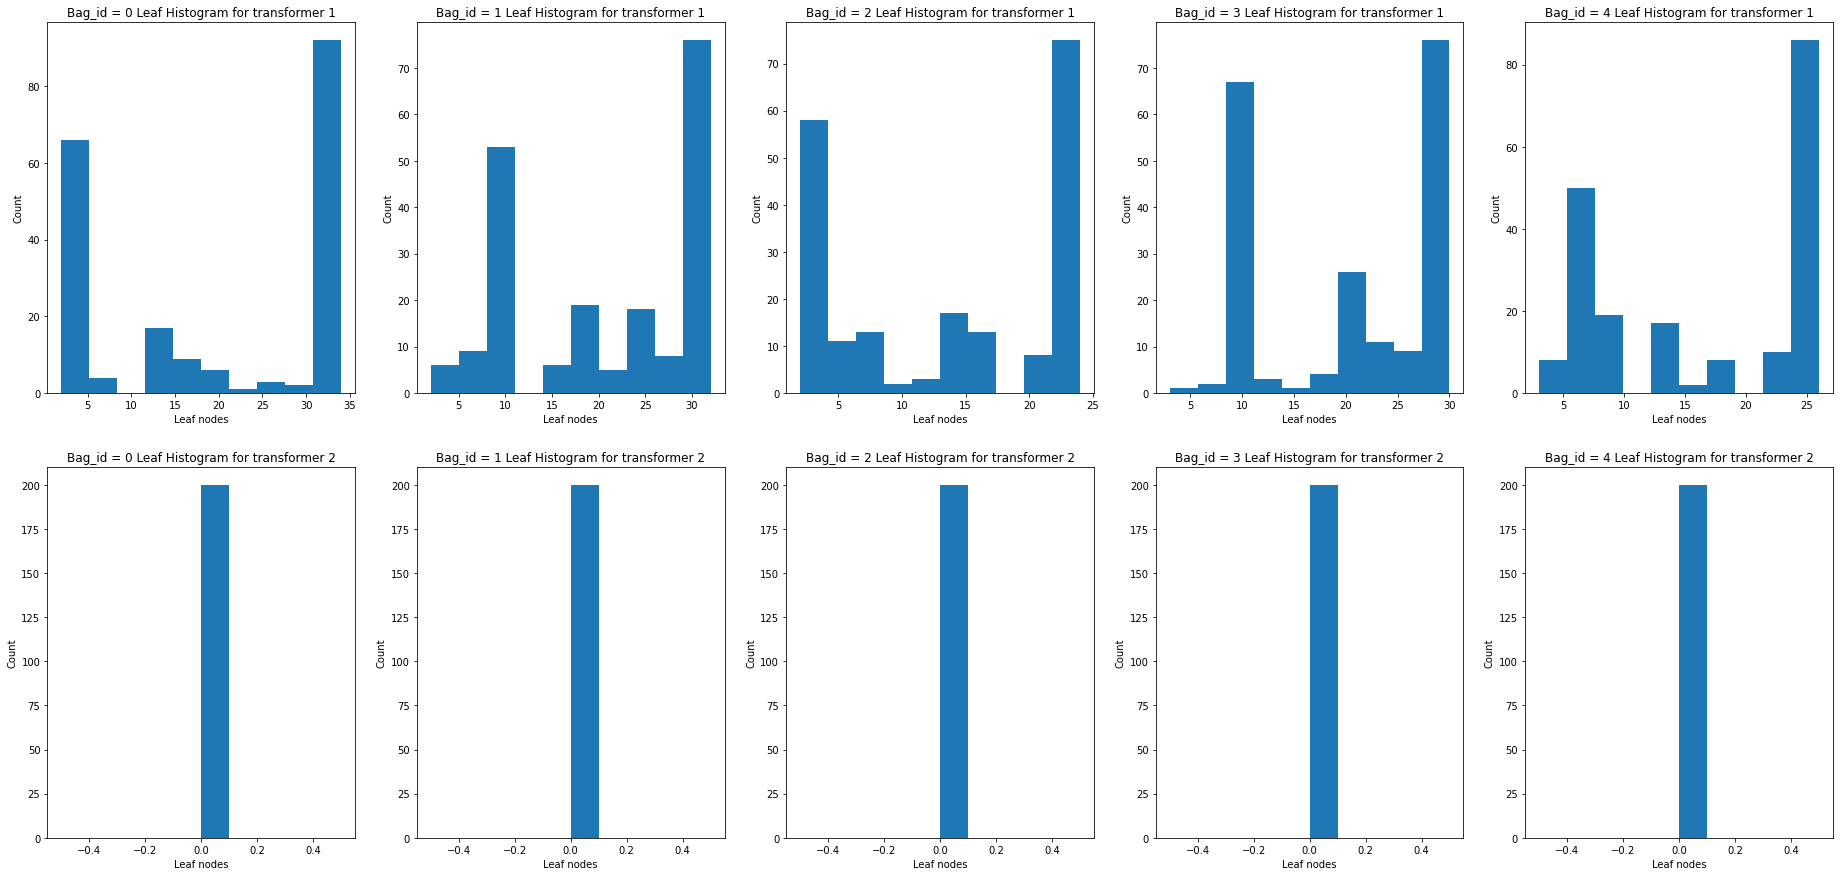

In [104]:
r = 2
c = 5
plt.figure(figsize=(32,15))

for i in range(c):
    ax = plt.subplot(r, c, i+1)
    ax.hist(leaf_nodes_0[i])
    ax.set_title('Bag_id = ' + str(i) + ' Leaf Histogram for transformer 1')
    ax.set_xlabel('Leaf nodes')
    ax.set_ylabel('Count')
    
for i in range(c):
    ax = plt.subplot(r, c, i+6)
    ax.hist(leaf_nodes_1[i])
    ax.set_title('Bag_id = ' + str(i) + ' Leaf Histogram for transformer 2')
    ax.set_xlabel('Leaf nodes')
    ax.set_ylabel('Count')